In [6]:
import random
import matplotlib.pyplot as plt

In [7]:
def liters_to_gal(liters: float) -> float:
    return liters / 3.78541

In [8]:
# Define constants

# Time
FLIGHT_DAYS: int = 214
COLONY_DAYS: int = 3650

NUM_PEOPLE = 20

# ISS has 1920 liters of water for 7 people for 3 months
# https://ntrs.nasa.gov/api/citations/20180006341/downloads/20180006341.pdf
START_WATER = (7/3) * liters_to_gal(1920 * (NUM_PEOPLE / 7))

# https://www.nasa.gov/sites/default/files/atoms/files/mars_ice_drilling_assessment_v6_for_public_release.pdf
MAX_WATER_STORED = (NUM_PEOPLE) * liters_to_gal(1000 * 20)

END_OF_WATER_RATIONING = 60

MINING_FAIL_CHANCE = 0.05

MINING_SETUP_PERIOD = 60
DAYS_UNTIL_FARMING = 60
FARMING_WATER_USED = 140 / 7 # Soybeans require 140 gal per week

WATER_RATION_THRESHOLD = START_WATER * 2

RECYCLE_PERCENTAGE: float = 0.85

In [9]:
water_stored: float = START_WATER

# Water Extraction
total_water_gained: int = 0

# Simulation
current_water = 0


def get_recycle_percentage() -> float:
    return (RECYCLE_PERCENTAGE + (random.random() * 0.1) - 0.05)


# Returns a random percentage up to 10% to indicate alteration
def get_water_deviation() -> float:
    #-5% to 5% deviation
    return random.random() * 0.2 - 0.1

    # Returns the water usage for an individual with the alterations accounted for


def get_individual_water_usage(base_water: float) -> float:
    return base_water * (1 + get_water_deviation())


def get_individual_space_water_usage() -> "tuple[float, float]":
    water_used = 0
    water_recycled = 0

    # ISS Astronauts use 3 gal per day
    water_used = 3
    water_used *= (1 + get_water_deviation())
    water_recycled = get_recycle_percentage() * water_used

    return (water_used, water_recycled)

In [10]:
def simulate(water_mined_per_day: float) -> 'tuple(bool, float, float)':
    total_water_used = 0
    total_water_lost = 0
    total_water_recycled = 0
    total_water_gained = 0
    water_stored = 0

    failed :bool = False

    water_stored = START_WATER
    days_survived = 0

    # During Flight
    for day in range(1, FLIGHT_DAYS + 1):
        failed = water_stored <= 0
        if failed:
            break

        days_survived += 1
        water_used_today = 0
        water_lost_today = 0
        water_recycled_today = 0

        for x in range(NUM_PEOPLE):
            individual_water, individual_recycled = get_individual_space_water_usage()
            water_used_today += individual_water
            water_recycled_today += individual_recycled

        water_lost_today = water_used_today - water_recycled_today

        total_water_used += water_used_today
        total_water_lost += water_lost_today
        total_water_recycled += water_recycled_today

        water_stored -= water_lost_today
        water_stored = max(water_stored, 0)

    colonization_water_used = 0.0
    colonization_water_lost = 0.0
    colonization_water_gained = 0.0
    colonization_water_recycled = 0.0

    days_failing = 0
    fail_percent = 0
    mining_efficiency = 1

    # During Colonization
    for day in range(1, COLONY_DAYS + 1):
        if failed:
            break
        
        days_survived += 1
        failed = water_stored <= 0
        water_used_today = 0
        water_lost_today = 0
        water_recycled_today = 0

        for x in range(NUM_PEOPLE):
            # Colonists split up water rations over a schedule 
            cycle = x + day
            if water_stored < WATER_RATION_THRESHOLD:
                # 2.5 gal hygiene
                # 1 gal drinking
                individual_water = get_individual_water_usage(3.5)
                if cycle % 3 == 0:
                    # shower (20 gal) (every 3 days)
                    individual_water += get_individual_water_usage(20)
                if cycle % 4 == 0:
                    # Washing machine (15 gal) (every 4 days)
                    individual_water += get_individual_water_usage(15)
                if cycle % 2 == 0:
                    # Dishwasher (5 gal) (every 2 days)
                    individual_water += get_individual_water_usage(5)
            elif water_stored < START_WATER:
                # if there is nearly no water, cut water usage to only basic needs
                individual_water = get_individual_water_usage(3.5)
            else:
                # 5 gal dishwasher
                # 20 gal shower
                # space toilet = no water
                # 2.5 gal hygiene
                # 1 gal drinking
                individual_water = get_individual_water_usage(5 + 20 + 2.5 + 1)
                if cycle % 4 == 0:
                    # Washing machine (15 gal) (every 4 days)
                    individual_water += get_individual_water_usage(15)
            water_used_today += individual_water
            water_recycled_today += individual_water * get_recycle_percentage()

        if day > DAYS_UNTIL_FARMING:
            water_used_today += FARMING_WATER_USED

        water_lost_today = water_used_today - water_recycled_today

        # Mining productivity goes up 5% at a time for the first 30 days
        setup_factor = round(min(1, day / MINING_SETUP_PERIOD) * 20) / 20

        # 20% deviation in mining + setup factor
        water_mined_today = water_mined_per_day * (1 + random.random() * 0.4 - 0.2) * setup_factor * mining_efficiency

        # Mining efficiency will vary by up to +-5%
        mining_efficiency += (random.random() * 0.1 - 0.05)
        # Mining efficiency goes from 20 - 100%
        mining_efficiency = max(min(1, mining_efficiency), 0.2)

        # A machine can fail for up to 5 days
        if (random.random() < MINING_FAIL_CHANCE):
            days_failing = random.randint(1, 5)
            fail_percent = random.random()

        if (days_failing > 0):
            water_mined_today *= fail_percent
            days_failing -= 1

        water_gained_today = water_mined_today

        colonization_water_lost += water_lost_today
        colonization_water_used += water_used_today
        colonization_water_recycled += water_recycled_today
        colonization_water_gained += water_gained_today
        
        total_water_lost += water_lost_today
        total_water_used += water_used_today
        total_water_recycled += water_recycled_today
        total_water_gained += water_gained_today

        water_stored += water_gained_today - water_lost_today
        # Stop water stored from exceeding max
        water_stored = min(water_stored, MAX_WATER_STORED)
        water_stored = max(water_stored, 0)
    
    return (not failed, water_stored, days_survived)

In [13]:
def run():
    NUM_TRIALS = int(input("How many trials would you like to run for each colony? (Note: Large numbers will take longer to calculate) "))

    success_rate_dict = {}
    water_left_dict = {}
    days_survived_dict = {}

    for daily_water_mined in range(50, 425, 25):
        successes = []
        water_left_list = []
        days_survived_list = []
        for _ in range(NUM_TRIALS):
            success, water_left, days_survived = simulate(daily_water_mined)
            successes.append(success)
            water_left_list.append(water_left)
            days_survived_list.append(days_survived)

        success_rate_dict[daily_water_mined] = 100 * successes.count(True) / len(successes)
        water_left_dict[daily_water_mined] = sum(water_left_list) / len(water_left_list)
        days_survived_dict[daily_water_mined] = sum(days_survived_list) / len(days_survived_list)
    
    mining_rates = []
    success_rates = []
    water_left = []
    days_survived = []

    for mining_rate in success_rate_dict.keys():
        mining_rates.append(mining_rate)
        success_rates.append(success_rate_dict[mining_rate])
        water_left.append(water_left_dict[mining_rate])
        days_survived.append(days_survived_dict[mining_rate])


    fig, axs = plt.subplots(3, 1, sharex=True)
    fig.set_size_inches(10, 6)
    fig.suptitle("Water Usage on Mars")
    fig.supxlabel("Daily water mining capacity (gal)")
    fig.subplots_adjust(hspace=0.12)

    success_plot = axs[0].plot(mining_rates, success_rates, c="limegreen", lw=3)
    axs[0].set_ylim(0, 110)
    axs[0].set_ylabel("Colony survival rate")

    max_survival = axs[0].plot(mining_rates, [
                            100 for rate in mining_rates], linestyle="--", color="lawngreen")


    water_plot = axs[1].plot(mining_rates, water_left, c="blue", lw=3)
    axs[1].set_ylim(0, max(water_left) + 10000)
    axs[1].set_ylabel("Average water left (gal)")

    max_water = axs[1].plot(mining_rates, [MAX_WATER_STORED for rate in mining_rates], linestyle="--", color="cornflowerblue")

    survival_plot = axs[2].bar(mining_rates, days_survived, width=20, color="cadetblue")
    axs[2].set_ylabel("Average Days Survived")
    # success_plot.

    plt.show()

How many trials would you like to run for each colony? (Note: Large numbers will take longer to calculate) 1


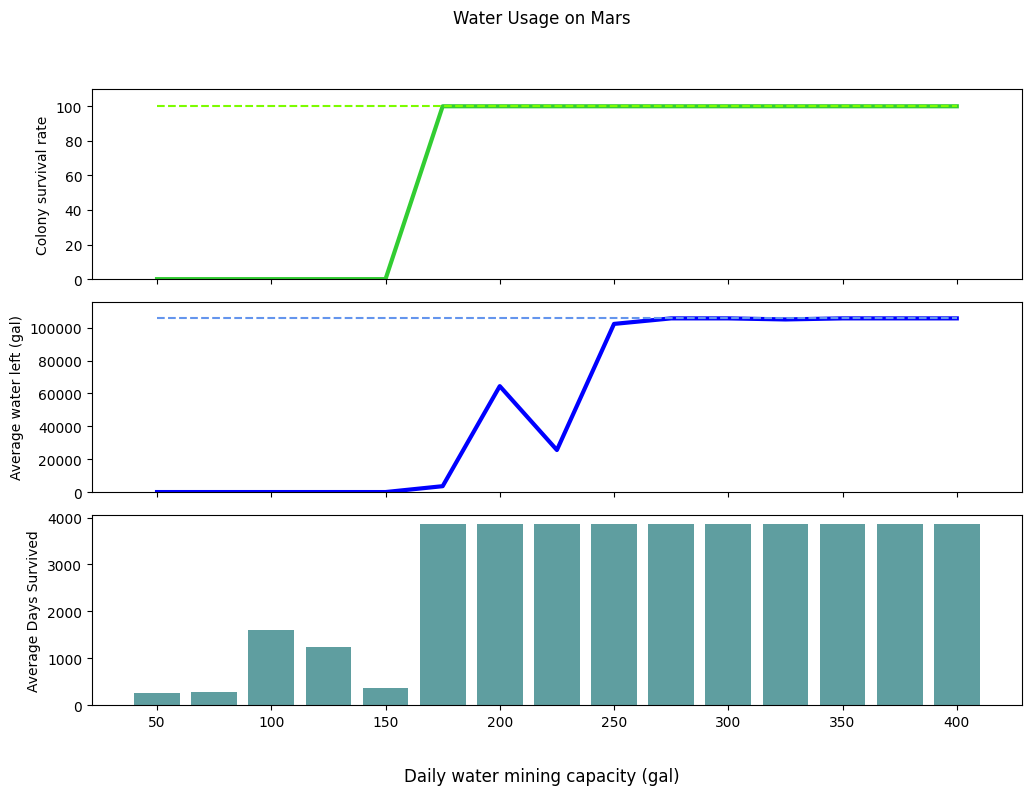

In [14]:
run()